# Market generator Bühler - Geometric Brownian Motion (Black-Scholes setting)

In [52]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import BuehlerVAE.src.market_generator as market_generator
from BuehlerVAE.src.utils import tosig

## Load monthly paths

In [53]:
# Signature order
order = 4
# random seed
seed = 42 

In [54]:
ticker = "^GSPC"
method = "Kou_Jump_Diffusion"
freq = "Y"
params = {
    "S0": 1., 
    "mu": 0.12, 
    "sigma": 0.2, 
    "lambda_": 2.0, 
    "p": 0.3, 
    "eta1": 50., 
    "eta2": 25., 
    "n": 1000
}
MG = market_generator.MarketGenerator(ticker, freq=freq, sig_order=order, own_params=params, method=method, seed=42)

Computing log-signatures: 100%|██████████| 1000/1000 [00:00<00:00, 1204.76it/s]


## Plot paths

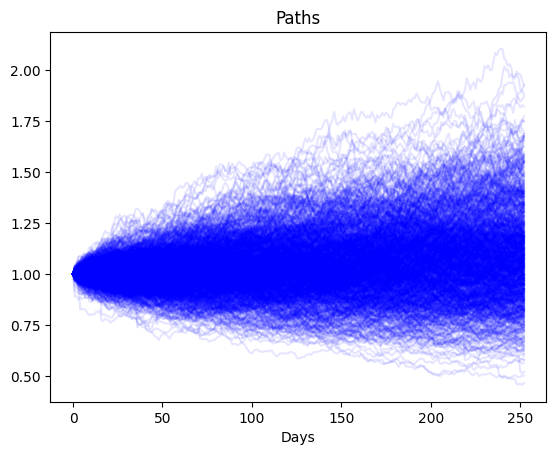

In [55]:
for path in MG.windows:
    returns = path[::2, 1]
    plt.plot(returns, "b", alpha=0.1)


plt.title("Paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [56]:
MG.train(n_epochs=10000)

Training: 100%|██████████| 10000/10000 [00:23<00:00, 421.62it/s]


## Generate

In [57]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|██████████| 1000/1000 [00:15<00:00, 66.30it/s]


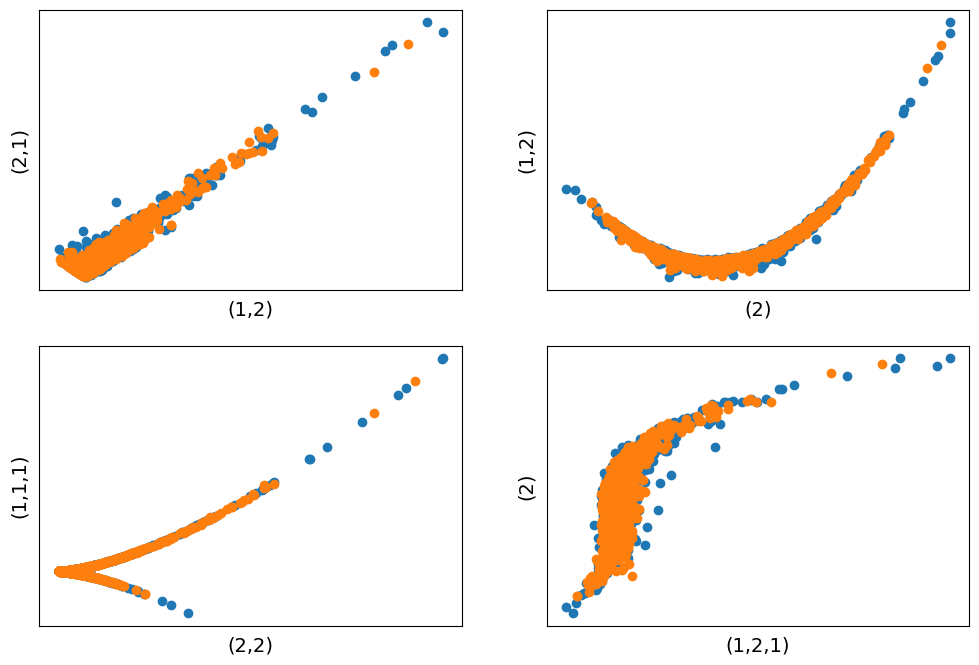

In [58]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [59]:
import BuehlerVAE.src.process_discriminator as process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
# new seed here, i.e. "out of sample" test
MG.seed = 43
MG._load_own_data(params, method)
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 2: 100%|██████████| 999/999 [00:00<00:00, 2182.67it/s]

Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [60]:
import BuehlerVAE.src.logsig_inversion as logsig_inversion
from esig.tosig import stream2logsig
from BuehlerVAE.src.utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [61]:
pip = 0.001 if freq == "M" else 0.0001
n_pips = 50 if freq == "M" else 100
n_points = 22 if freq == "M" else 253

n_iterations = 100 if freq == "M" else 100
n_organisms = 100 if freq == "M" else 150

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

Loss: 0.0368604221820906: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s] 


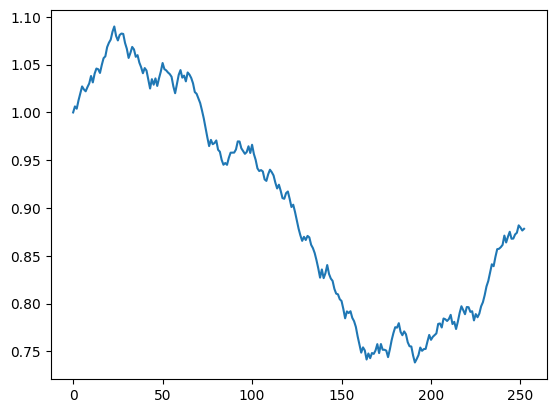

Target log-signature: [-0.1221085786819458, -0.1213778704404831, -0.01910577528178692, 0.0001634788204682991, 0.00018931334489025176, -3.0040842830203474e-05, -6.114352436270565e-05, -3.171676507918164e-05]
Recovered log-signature: [-0.12169999999999992, -0.12169999999999992, -0.004843735000000005, 0.00017235254058333373, 0.00017385813041666587, -3.122924753069984e-05, -6.245732166845405e-05, -3.125401980365003e-05]


In [62]:
plt.plot(1 + recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [63]:
recovered_paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    recovered_paths.append(recovered_path)

# We currently accept randomness in log-signature inversion without seed

Loss: 0.12379102668055292: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


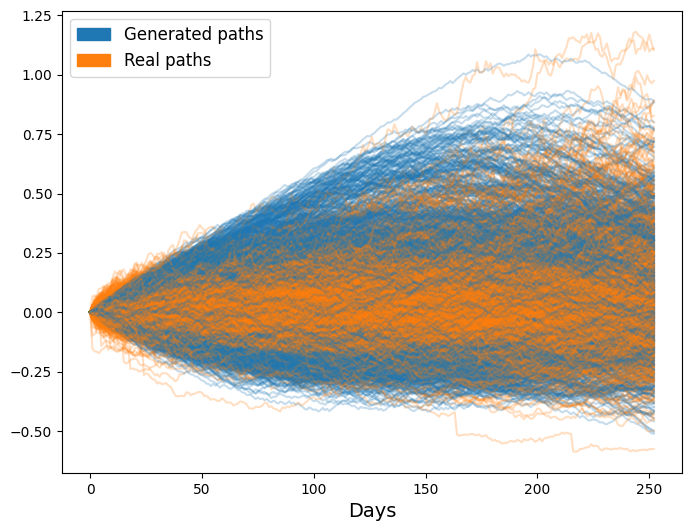

In [64]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(recovered_paths, MG.windows):
    returns = path2[::2, 1] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1, "C0", alpha=0.25)
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
name_string = f"_{method}_{params['n']}_{freq}"
plt.savefig(f"plots/paths{name_string}")
plt.show()

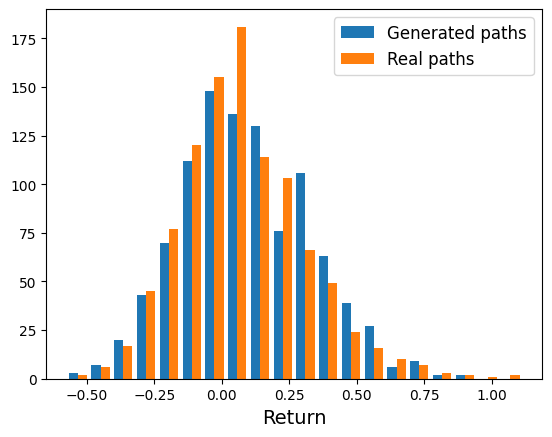

In [65]:
# This graph is somewhat week as the return over the whole month can be #
# extracted from the signature directly from the first order terms (also for log-signature?)
returns1 = [path[-1] - path[0] for path in recovered_paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Generated paths", "Real paths"])
plt.xlabel("Return", fontsize=14)
plt.legend(fontsize=12)
plt.savefig(f"plots/hist{name_string}")
plt.show()

In [66]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

In [67]:
# idx = 50

# condition = MG.conditions[idx]

# paths = [concatenate(condition, 12) for _ in range(10)]

# plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
# plt.xlabel("Days", fontsize=14) 
# plt.show()

In [68]:
# Export to csv
import pandas as pd
# Convert paths to pandas DataFrames
recovered_paths_df = pd.DataFrame(recovered_paths)
mg_windows_df = pd.DataFrame([path[::2, 1] - path[0, 1] for path in MG.windows])

# Save the DataFrames to CSV files
name_string += ".csv"
recovered_paths_df.to_csv("csv_export/recovered_paths"+name_string, index=False)
mg_windows_df.to_csv("csv_export/mg_windows"+name_string, index=False)